#### 라이브러리 로드

In [1]:
# !pip install efficientnet

In [2]:
# !pip install tensorflow_addons

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import sys
import os
efficientdet_dir = '/content/drive/MyDrive/광운대학교 관련/23y 여름 연구참여/efficientdet'
sys.path.append(efficientdet_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import json
from pathlib import Path

from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt

import efficientdet

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### 사용가능한 GPU 확인

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8190343771613028339
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15208677376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 96347688466270986
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]


훈련하고자하는 모델 선택 (D-0 ~ D-7)

In [7]:
D = 2 #@param {type: "slider", min: 0, max: 7}

In [8]:
model_config = efficientdet.config.EfficientDetCompudScaling(D=D)
im_size = model_config.input_size

print('Working with images of shape (H, W):', im_size)

Working with images of shape (H, W): (768, 768)


dataset 불러오기

In [9]:
os.chdir('/content/drive/MyDrive/광운대학교 관련/23y 여름 연구참여/efficientdet/examples')

In [10]:
data_path = Path('../dataset')
class_names_file = data_path / 'data_labels.names'
!cat {str(class_names_file)}
class_names_file

crosswalk
LeftTurn
NoLeftTurn
RightTurn
Straight

PosixPath('../dataset/data_labels.names')

`read_class_names`로 class name 매핑

In [11]:
classes, class2idx = efficientdet.utils.io.read_class_names(class_names_file)
class2idx

{'crosswalk': 0, 'LeftTurn': 1, 'NoLeftTurn': 2, 'RightTurn': 3, 'Straight': 4}

`image.jpg`, `image.json` 모두 불러오기

In [12]:
root_data = data_path / 'train_test'
sample_images = list(root_data.glob('*.jpg'))[:3]
sample_annots = [root_data / f'{p.stem}.json' for p in sample_images]

for im_f, annot_f in zip(sample_images, sample_annots):
    print('Image:', str(im_f), '--> Annot:', str(annot_f))

Image: ../dataset/train_test/0405170708_601.9017.jpg --> Annot: ../dataset/train_test/0405170708_601.9017.json
Image: ../dataset/train_test/0405170707_600.79.jpg --> Annot: ../dataset/train_test/0405170707_600.79.json
Image: ../dataset/train_test/0405170709_602.9464.jpg --> Annot: ../dataset/train_test/0405170709_602.9464.json


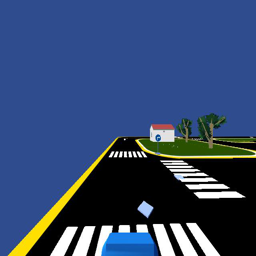

In [13]:
#이미지 확인
Image.open(sample_images[0]).resize((256, 256))

json을 로드 -> `shapes` 속성 : 사각형 pint & class 정보 포함

In [14]:
json.load(sample_annots[0].open())['shapes']

[{'label': 'crosswalk',
  'points': [[270.2475247524753, 282.0792079207921],
   [369.7524752475247, 296.9306930693069]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': 'crosswalk',
  'points': [[396.980198019802, 299.4059405940594],
   [615.7920792079208, 374.1584158415842]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': 'crosswalk',
  'points': [[120.24752475247523, 415.2475247524753],
   [551.1280472585072, 480.0]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': 'RightTurn',
  'points': [[389.55445544554453, 252.3762376237624],
   [402.4257425742574, 265.2475247524753]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}}]

In [15]:
# 데이터 셋 build
ds = efficientdet.data.labelme.build_dataset(
    annotations_path=root_data,
    images_path=root_data,
    class2idx=class2idx,
    im_input_size=im_size,
    shuffle=True)

image, (labels, bbs) = next(iter(ds))

print('Image shape:', image.shape)
print('Labels shape:', labels.shape)
print('Bounding boxes shape:', bbs.shape)

Image shape: (768, 768, 3)
Labels shape: (5,)
Bounding boxes shape: (5, 4)


The types and shapes are:

| element | dtype | shape |
|--------|--------|-----------
| image | tf.float32 | [HEIGHT, WIDTH, 3] |
| labels | tf.int32 | [N_ELEMS] |
| boxes | tf.float32 | [N_ELEMS, 4] |

Boxes are always formated as (x_min, y_min, x_max, y_max) and using absolute image sizes.

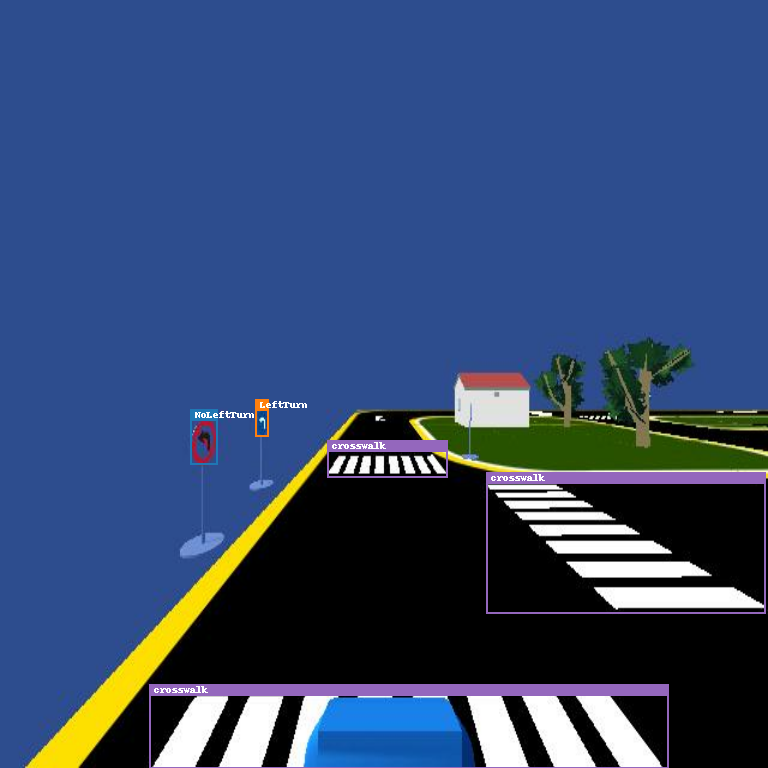

In [16]:
# image 및 label 함께 확인 시각화
image, (labels, bbs) = next(iter(ds))

image_n = efficientdet.data.preprocess.unnormalize_image(image)

labels_name = [classes[l] for l in labels.numpy().tolist()]
colors = efficientdet.visualizer.colors_per_labels(labels_name)

efficientdet.visualizer.draw_boxes(image_n, bbs, labels_name, colors=colors)

train, validation dataset 나누기

In [17]:
ds_len = sum(1 for _ in ds)

train_len = int(ds_len * .9) # 90% of validation data

train_ds = ds.take(train_len) # Take the first instances
valid_ds = ds.skip(train_len) # Skip the first instances, so the sets do not intersect

# Data augmentation on training set
train_ds = (train_ds
            .map(efficientdet.augment.RandomCrop()))

# .map(efficientdet.augment.RandomHorizontalFlip())

In [18]:
batch_size = 4 #@param {type: "slider", min: 2, max: 64}

In [19]:
padded_image_shape = (*im_size, 3)
padded_labels_shape = (None,)
boxes_padded_shape = (None, 4)

train_ds = train_ds.padded_batch(batch_size=batch_size,
                                 padded_shapes=(padded_image_shape,
                                                (padded_labels_shape,
                                                 boxes_padded_shape)),
                                 padding_values=(0., (-1, -1.)))

valid_ds = valid_ds.padded_batch(batch_size=batch_size,
                                 padded_shapes=(padded_image_shape,
                                                (padded_labels_shape,
                                                 boxes_padded_shape)),
                                 padding_values=(0., (-1, -1.)))

In [20]:
wrapped_train_ds = efficientdet.wrap_detection_dataset(
        train_ds, im_size=im_size, num_classes=len(class2idx))

wrapped_valid_ds = efficientdet.wrap_detection_dataset(
        valid_ds, im_size=im_size, num_classes=len(class2idx))

## Training

In [21]:
epochs = 100 #@param {type: "slider", min: 2, max: 120}

#@markdown Compute COCO mAP every `valdiate_freq` epochs
valdiate_freq = 10 #@param {type: "slider", min: 1, max: 10}


VOC2007 데이터 셋에서 사전 훈련된 가중치를 사용하여 EfficientDet 사용

5개 parameter 설정
- `D`: EfficientDet 모델 선택
- `num_classes`: 데이터 세트에서 사용 가능한 클래스 `len(class2idx)`.
- `training_mode`: 학습할 때 'True'로 설정합니다.

In [22]:
# model = efficientdet.EfficientDet(D=D,
#                                   num_classes=len(class2idx),
#                                   training_mode=True,
#                                   weights='D0-VOC',
#                                   custom_head_classifier=True)

In [27]:
model = efficientdet.EfficientDet(D=D,
                                  num_classes=len(class2idx),
                                  training_mode=True)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore('/content/drive/MyDrive/광운대학교 관련/23y 여름 연구참여/efficientdet/checkpoints/efficientdet-d2/model')

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


optimizer, optimizer scheduler 로드

In [28]:
# We have to calculate the steps per epoch in order to create the
# learning rate scheduler
steps_per_epoch = sum(1 for _ in wrapped_train_ds)
lr = efficientdet.optim.WarmupCosineDecayLRScheduler(
            1e-4,
            warmup_steps=steps_per_epoch,
            decay_steps=steps_per_epoch * (epochs - 1),
            alpha=0.1)

# optimizer = tfa.optimizers.AdamW(learning_rate=lr,
#                                  weight_decay=4e-5)

optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=lr, decay=4e-5
)

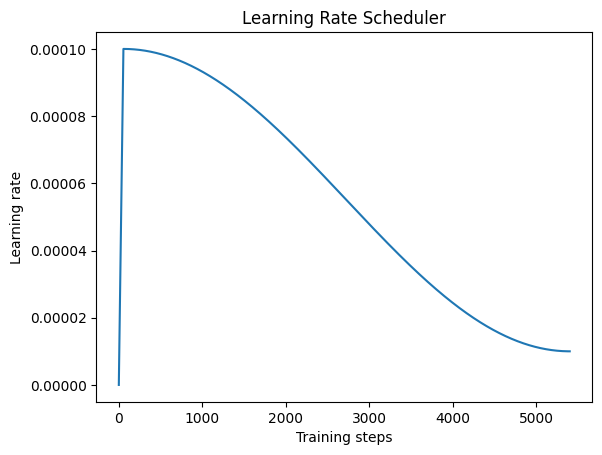

In [29]:
lrs = [lr(o) for o in range(steps_per_epoch * epochs)]

plt.plot(range(len(lrs)), lrs)
plt.xlabel('Training steps')
plt.ylabel('Learning rate')
plt.title('Learning Rate Scheduler')
plt.show();

model complie 및 model trian

In [30]:
clf_loss = efficientdet.losses.EfficientDetFocalLoss()
reg_loss = efficientdet.losses.EfficientDetHuberLoss()

model.compile(loss=[reg_loss, clf_loss],
              optimizer=optimizer, loss_weights=[1., 1.])

model.build([None, *im_size, 3])
model.summary()

Model: "efficient_det_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientNetB2 (Functional)  [(None, None, None, 96),  7768562  
                              (None, None, None, 144)            
                             , (None, None, None, 288            
                             ),                                  
                              (None, None, None, 720)            
                             , (None, None, None, 140            
                             8)]                                 
                                                                 
 bi_fpn_3 (BiFPN)            multiple                  3080707   
                                                                 
 retina_net_classifier_3 (Re  multiple                 51549     
 tinaNetClassifier)                                              
                                                   

In [32]:
# model train
callbacks = [
    efficientdet.callbacks.COCOmAPCallback(valid_ds,
                                           class2idx,
                                           validate_every=valdiate_freq)
]

with tf.device("/device:GPU:0"):
    history = model.fit(wrapped_train_ds,
            validation_data=wrapped_valid_ds,
            epochs=epochs,
            callbacks=callbacks)

creating index...
index created!
Epoch 1/100


TypeError: ignored

`training_mode`를 `False`로 설정하고 `score_threshold`를 변경하면서 조정

In [ ]:
model.training_mode = False
model.filter_detections.score_threshold = 0.7 # 0.2이상인 모든 bbox를 표현함

In [ ]:
# random image 1장에 대한 예측 시각화

image, _ = next(iter(valid_ds.unbatch().shuffle(20).take(1)))

bbs, labels, scores = model(tf.expand_dims(image, 0), training=False)

image_n = efficientdet.data.preprocess.unnormalize_image(image)

# Covert dataset labels to names
labels_name = [classes[l] for l in labels[0].numpy().tolist()]

# For each different name get a color
colors = efficientdet.visualizer.colors_per_labels(labels_name)

# Get a Pillow image with drew boxes, and automatically plot it
efficientdet.visualizer.draw_boxes(
    image_n, bbs[0], labels_name, scores=scores[0], colors=colors)